### Dataset classification to determine sampling proportions

LLMs are often trained on data from different sources, where the sources are weighted in a certain way. Using dataset classification, it can be possible to infer the weights of the data sources. Specifically, let $\mathbf x = [x_1,...,x_n]$ be the vector containing the sampling weights (with $\sum_i x_i = 1, x_i\geq 1$). 

We first take the LLM and generated a testdataset from it. 

We then define a comparision function compare($\mathbf x, \mathbf x'$) which trains a classifier to distingush data with weights $\mathbf x$ from data with weights $\mathbf x'$. The classifier is then applied to the test data and returns one if the data is more likely to be from the data with weights $\mathbf x$ than from the data with weights $\mathbf x'$. The classifier returns one if that's the case and zero otherwise.

We then perform zero-order optimization with gradientless descent as implemented below. For the toy example below this works well, let's see how well it works in reality. 


In [2]:
# import numpy
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# function to project on the probability simplex, 
# i.e., the vector x is projected to the closest vector in l2-norm on the simplex
def proj_simplex(y):
    m = len(y)
    bget = False
    s = sorted(y, reverse=True) # sorting in descending order
    tmpsum = 0
    for i in range(m-1):
        tmpsum = tmpsum + s[i]
        tmax = (tmpsum - 1) / (i+1)
        if tmax >= s[i+1]:
            bget = True
            break
    if not bget:
        tmax = (tmpsum + s[m-1] -1) / m
    return np.maximum(y-tmax,0)

# test the function
N = 5
x = np.random.randn(N)
print(x)
x = proj_simplex(x)
print(x, sum(x))

[ 0.03540964  0.38505443  2.64527472  0.70491786 -0.77422529]
[0. 0. 1. 0. 0.] 1.0


In [4]:
# generate a toy problem instance
N = 7
# random weights
#xorig = proj_simplex( np.random.rand(N))
# llama weights
xorig = np.array([0.67,0.15,0.045,0.045,0.045,0.025,0.02])

# this is for our toy problem, need to implement the actual comparision function as descrived above
def comparison(xa,xb,xorig):
    # return 1 if xa is closer to xorig, -1 if xb is closer
    diff1 = np.linalg.norm(xa-xorig)
    diff2 = np.linalg.norm(xb-xorig)
    if diff1 < diff2:
        return 1
    else:
        return -1


loss at the end of the run:  0.008054702216501005


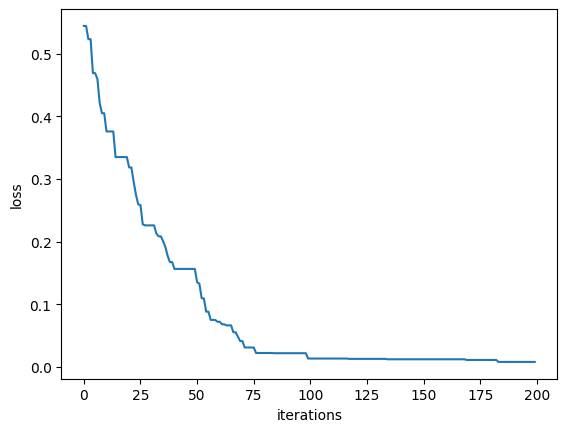

In [8]:
# gradientless descent for finding xorig based only on comparisions
def gradientless_descent(xorig, N,num_iter=200,radius = 0.2,alpha=0.5):
    # initialize x with equal probability
    x = np.ones(N)/N
    #x = np.random.rand(N)
    #x = proj_simplex(x)
    
    func_vals = []
    
    for i in range(num_iter):
        stepsize = 1/(i+1)**alpha
        # choose random direction with radius R
        dir = np.random.randn(N)
        dir = dir/np.linalg.norm(dir)*radius*stepsize
        xcandidate = proj_simplex( x + dir )
        # compare x with x+dir and update x
        if comparison(xcandidate,x,xorig) == 1:
            x = xcandidate

        func_vals.append(np.linalg.norm(x-xorig))
    return x, func_vals


# example run with default parameters
x, func_vals = gradientless_descent(xorig,N)
print("loss at the end of the run: ", np.linalg.norm(x-xorig))
plt.plot(func_vals)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

loss at the end of the run:  0.0478716011463714


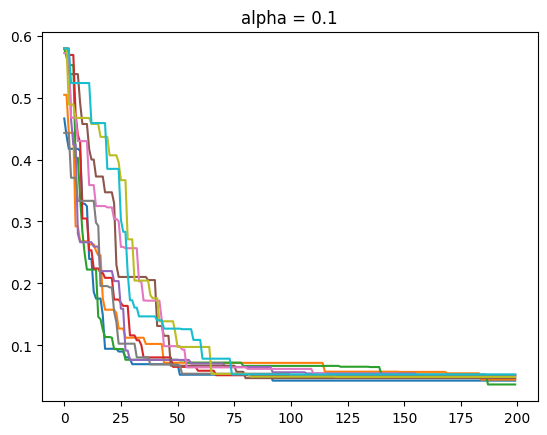

loss at the end of the run:  0.03228934616508944


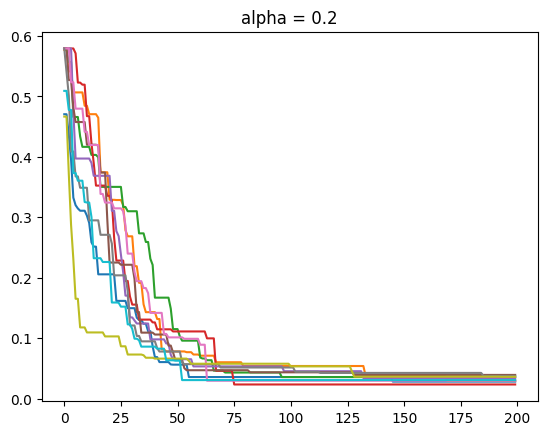

loss at the end of the run:  0.021510510487106622


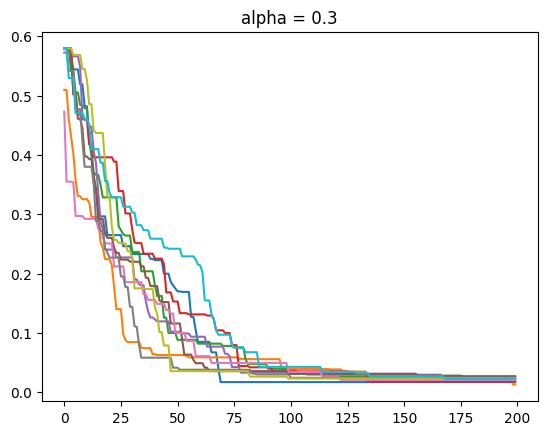

loss at the end of the run:  0.013034986442093615


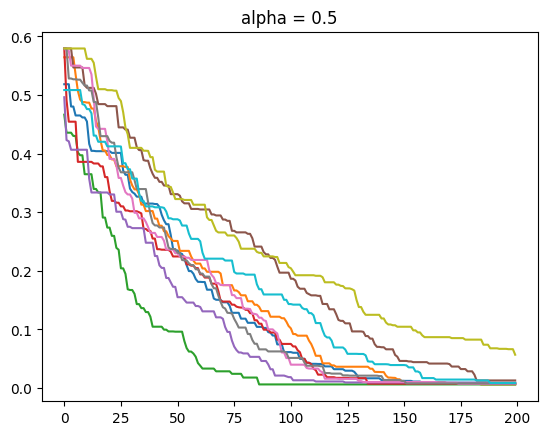

In [6]:
# what's a good value for alpha? Looks like for enough iterations, alpha = 0.5 is best

num_iter = 200

for alpha in [0.1,0.2,0.3,0.5]:
    val_end = []
    for i in range(10):
        x, func_vals = gradientless_descent(xorig, N, num_iter=num_iter,radius = 0.2,alpha=alpha)
        plt.plot(func_vals)
        val_end.append(func_vals[-1])
    print("loss at the end of the run: ", np.mean(val_end))
    plt.title('alpha = '+str(alpha))
    plt.show()
